In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
import tensorflow as tf

from tqdm import tqdm
from numba import njit

from msfm.utils.input_output import read_yaml

Redshift dependence of the bias parameter

In [2]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

z0 = 0.7
eta_fid = 0.5
b_fid = 1.5

# Metacal tomo bin
tomo_range = range(1, 5)
component = "g1"

### load redshift bins

[Text(0.5, 0, 'z'), Text(0, 0.5, 'n(z)')]

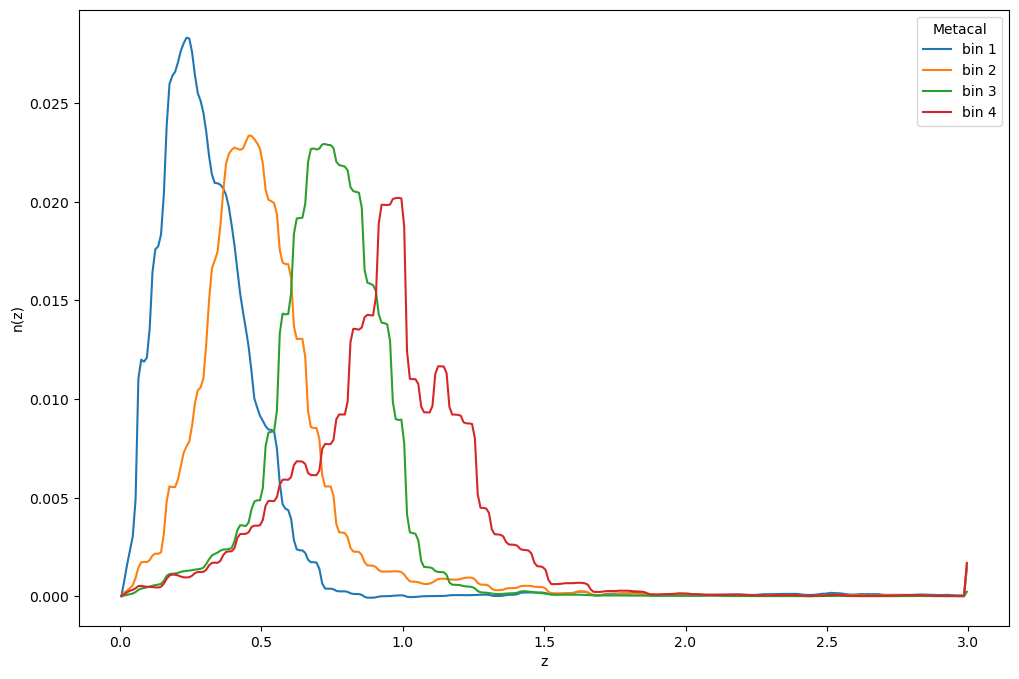

In [3]:
fig, ax = plt.subplots(figsize=(12,8))

z_tomo = []
nz_tomo = []
for tomo in tomo_range:
    z_bin_dir = f"../../data/redshift_distributions/desy3_nz_metacal_bin{tomo}.txt"
    redshift_dist = np.loadtxt(z_bin_dir)

    z = redshift_dist[:,0]
    nz = redshift_dist[:,1]

    ax.plot(z, nz, label=f"bin {tomo}")

    z_tomo.append(z)
    nz_tomo.append(nz)

ax.legend(title="Metacal")
ax.set(xlabel="z", ylabel="n(z)")

In [4]:
def get_tomo_bias(bg, n_bg):
    biases = []
    for i_tomo in range(4):
        z_bin_dir = f"../../data/redshift_distributions/desy3_nz_metacal_bin{i_tomo+1}.txt"
        redshift_dist = np.loadtxt(z_bin_dir)

        z = redshift_dist[:,0]
        nz = redshift_dist[:,1]

        f = nz * ((1+z)/(1+z0))**n_bg

        # This is the integral. There is no multiplication with dz because the nz already include this 
        fz = np.sum(f)/np.sum(nz)

        biases.append(fz*bg)
    
    return biases

print(get_tomo_bias(1.5, 0.5))

[1.3239316265939447, 1.4137321133389573, 1.515498187511085, 1.595469073271588]


In [5]:
biases = []
for z, nz in zip(z_tomo, nz_tomo):
    f = nz * ((1+z)/(1+z0))**eta_fid

    # This is the integral. There is no multiplication with dz because the nz already include this 
    fz = np.sum(f)/np.sum(nz)

    biases.append(fz*b_fid)

print(biases)

[1.3239316265939447, 1.4137321133389573, 1.515498187511085, 1.595469073271588]


In [6]:
# Original function for orientation

# from https://github.com/tomaszkacprzak/deep_lss/blob/3c145cf8fe04c4e5f952dca984c5ce7e163b8753/deep_lss/lss_astrophysics_model_batch.py#L267
@tf.function()
def get_mean_zevol(z0, eta, nz, zg, n_zbins, batch_size):
    """
    Get redshift evolution of a quantity
    """

    eta_e = tf.reshape(eta, shape=(batch_size, 1, 1))
    zg_e = tf.expand_dims(zg, axis=0)
    f = ((1+zg)/(1+z0))**eta_e
    fz = tf.reduce_sum(nz*f, axis=2)/tf.expand_dims(tf.reduce_sum(nz, axis=1), axis=0)

    return fz


# recreate MagLim values

In [7]:
import numpy as np
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [8]:
z0 = 0.7

# bins = [0,1,2,3,4,5]
bins = [0,1,3]

def get_maglim_bias(b_g, eta_b_g):
    b_g_i = []
    for tomo in bins:
        # load the distribution
        z_bin_dir = f"../../data/redshift_distributions/desy3_nz_maglim_bin{tomo+1}.txt"
        redshift_dist = np.loadtxt(z_bin_dir)
        z = redshift_dist[:,0]
        nz = redshift_dist[:,1]

        # integrand
        f = nz * ((1+z)/(1+z0))**eta_b_g

        # integral, there is no multiplication with dz because the nz already include this 
        fz = b_g * np.sum(f)/np.sum(nz)

        b_g_i.append(fz)

    return np.array(b_g_i)

# result from Table 1 in https://arxiv.org/pdf/2105.13546.pdf
b_g_target = np.array([1.40, 1.60, 1.82, 1.70, 1.91, 1.73])[bins]
b_g_errors = np.array([[0.09, 0.1, 0.1, 0.09, 0.1, 0.1], [0.1, 0.13, 0.13, 0.12, 0.14, 0.14]])[:,bins]

f = lambda x: np.mean((get_maglim_bias(x[0], x[1]) - b_g_target)**2)
x = minimize(f, [1, 1])["x"]

[Text(0.5, 0, 'redshift bin'),
 Text(0, 0.5, 'linear bias'),
 Text(0.5, 1.0, 'maglim')]

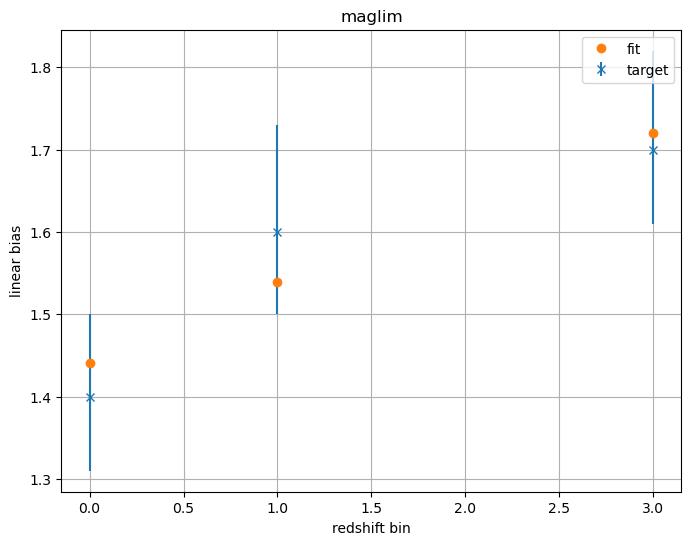

In [9]:
fig, ax = plt.subplots(figsize=(8,6))

ax.errorbar(x=bins, y=b_g_target, yerr=b_g_errors, label="target", linestyle="", marker="x")
ax.plot(bins, get_maglim_bias(x[0], x[1]), label="fit", linestyle="", marker="o")

ax.legend()
ax.grid(True)
ax.set(xlabel="redshift bin", ylabel="linear bias", title="maglim")